In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import networkx as nx

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

In [12]:
x_0, x_N = 0, 100
N_x = 10
T_sim = 4
N_t = 1000
I = 1.0

dx = (x_N - x_0)/(N_x)
dt = T_sim/N_t

In [83]:
def generate_converge():
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(N_x)] + [-i for i in range(1, N_x+1)])
    G.add_edges_from([(i,i+1) for i in range(N_x-1)] + [(-i-1, -i) for i in range(1,N_x)] + [(-1, int(N_x/2))])

    pos = {i: (i, 0) for i in range(N_x)} | {-i: (int(N_x/2), -i) for i in range(1, N_x+1)}
    return G, pos

def generate_diverge():
    pass

def generate_continuous():
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(N_x)])
    G.add_edges_from([(i,i+1) for i in range(N_x-1)])

    pos = {i: (i, 0) for i in range(N_x)}
    return G, pos

In [24]:
def init_converge(G):
    xs = jnp.linspace(x_0, x_N, N_x)
    for i,j in G.edges:
        if i<0:
            rho = rho_max/4
        else:
            rho = rho_max/4 #+ jnp.exp(-jnp.square((xs[i] - x_N/1.5)/20))*rho_max/2
        G.edges[i, j]['rho_old'] = rho
        G.edges[i, j]['Q_old'] = Q_e(rho)
        G.edges[i, j]['I'] = 1.

    return G

def init_continuous(G):
    xs = jnp.linspace(x_0, x_N, N_x)
    for i,j in G.edges:
        rho = rho_max/4
        #rho = rho_max/4 + jnp.exp(-jnp.square((xs[i] - x_N/2)/20))*rho_max/2
        G.edges[i, j]['rho_old'] = rho
        G.edges[i, j]['Q_old'] = Q_e(rho)

        if i==int(N_x/1.5):
            G.edges[i, j]['I'] = 0.0001
        else:
            G.edges[i, j]['I'] = 1.    
    return G

In [94]:
def plot_graph(G, pos, ax, title=''):
    weights = [float(G.edges[e]['rho_old']) for e in G.edges()]
    # Normalize the weights for colormap
    norm = plt.Normalize(min(weights), vmax=max(weights))

    ax.set_title(title)
    # Create the colormap
    cmap = plt.cm.viridis
    nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='-', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin=20, edge_vmax=40) #, edge_vmin = min(weights), edge_vmax=max(weights))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=ax)

In [104]:
def CTM_step(G, verbose=False):
    for i, j in G.edges:
        rho_k = G.edges[i, j]['rho_old']
        Q_k = G.edges[i, j]['Q_old']
        I_k = G.edges[i, j]['I']

        edges_k_m1 = G.in_edges(i, data=True)
        edges_k_p1 = G.out_edges(j, data=True)

        edge_in_j = G.in_edges(j, data=True)
        edge_out_i = G.out_edges(i, data=True)

        if len(edges_k_m1)==0:
            rho_k_m1 = -np.inf
            Q_k_m1 = np.inf
            D_k_m1 = np.where(rho_k_m1/I_k<=rho_C, Q_k_m1, C*I_k)
        else:
            D_k_m1 = 0
            for edge in edges_k_m1:
                data_k_m1_i = edge[2]
                rho_k_m1_i = data_k_m1_i['rho_old']
                Q_k_m1_i = data_k_m1_i['Q_old']
                I_k_m1_i = data_k_m1_i['I']
                D_k_m1_i = np.where(rho_k_m1_i/I_k_m1_i<=rho_C, Q_k_m1_i, C*I_k_m1_i)
                D_k_m1 += D_k_m1_i

        if len(edges_k_p1)==0:
            rho_k_p1 = np.inf
            Q_k_p1 = np.inf
            S_k_p1 = np.where(rho_k_p1/I_k>rho_C, Q_k_p1, C*I_k)
        else:
            data_k_p1 = next(iter(edges_k_p1))[2]
            rho_k_p1 = data_k_p1['rho_old']
            Q_k_p1 = data_k_p1['Q_old']
            I_k_p1 = data_k_p1['I']
            S_k_p1 = np.where(rho_k_p1/I_k_p1>rho_C, Q_k_p1, C*I_k_p1)

        D_k = 0
        for edge in edge_in_j:
            data_k_i = edge[2]
            rho_k_i = data_k_i['rho_old']
            Q_k_i = data_k_i['Q_old']
            D_k_i = np.where(rho_k_i/I_k<=rho_C, Q_k_i, C*I_k)
            D_k += D_k_i

        #D_k = np.where(rho_k/I_k<=rho_C, Q_k, C*I_k)
        S_k = np.where(rho_k/I_k>rho_C, Q_k, C*I_k)
        Q_up = np.minimum(S_k, D_k_m1)
        Q_down = np.minimum(S_k_p1, D_k)

        if verbose:
            if i==-1 or i==4:
                print('#i', i)
                print('S_k', S_k)
                print('D_k', D_k)
                print('D_k_m1', D_k_m1)
                print('S_k_p1', S_k_p1)
                print('rho', rho_k)
                print('Q_up', Q_up)
                print('Q_down', Q_down)
                print(len(edge_in_j))
            
        rho_k = rho_k + dt/dx*(Q_up - Q_down)

        G.edges[i, j]['rho_new'] = rho_k
        G.edges[i, j]['Q_new'] = I_k*Q_e(rho_k/I_k)

    for e in G.edges():
        G.edges[e]['rho_old'] = G.edges[e]['rho_new']
        G.edges[e]['Q_old'] = G.edges[e]['Q_new']
    
    return G

[]

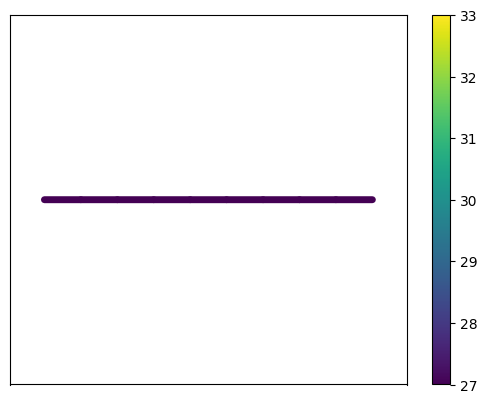

In [17]:
G, pos = generate_continuous()
G = init_continuous(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax)
plt.plot()

In [18]:
G = init_continuous(G)
G_checkpoints = []

for t_i in range(N_t+1):
    G = CTM_step(G)
    if t_i%200 == 0:
        G_checkpoints += [G.copy()]

[]

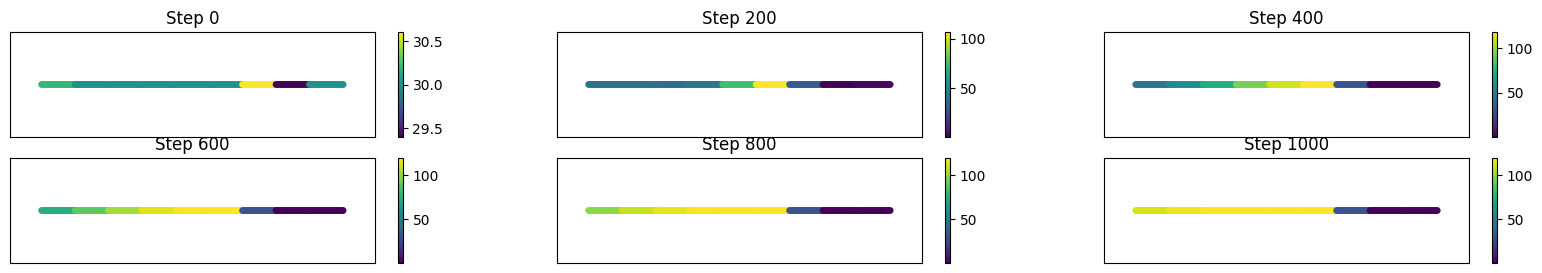

In [19]:
f, axs = plt.subplots(2, len(G_checkpoints)//2, figsize=(20,3))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*200}')

plt.plot()

In [21]:
G.edges[6, 7]

{'rho_old': 30.519919999999477,
 'Q_old': Array(0., dtype=float32),
 'I': 0.0001,
 'rho_new': 30.519919999999477,
 'Q_new': Array(0., dtype=float32)}

[]

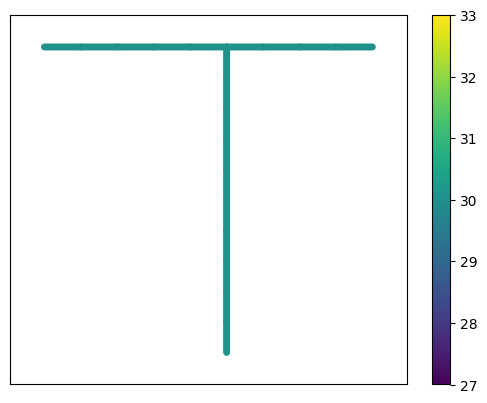

In [98]:
G, pos = generate_converge()
G = init_converge(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax, '')
plt.plot()

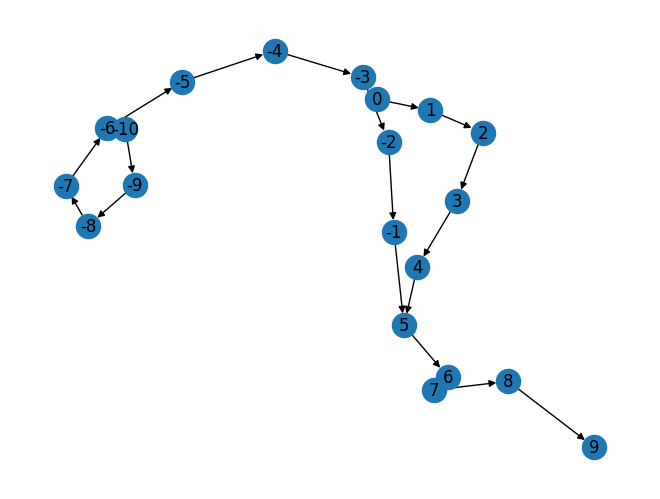

In [99]:
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

In [100]:
G = init_converge(G)
G_checkpoints = []

for t_i in range(N_t):
    G = CTM_step(G)
    if t_i%50 == 0:
        G_checkpoints += [G.copy()]

[]

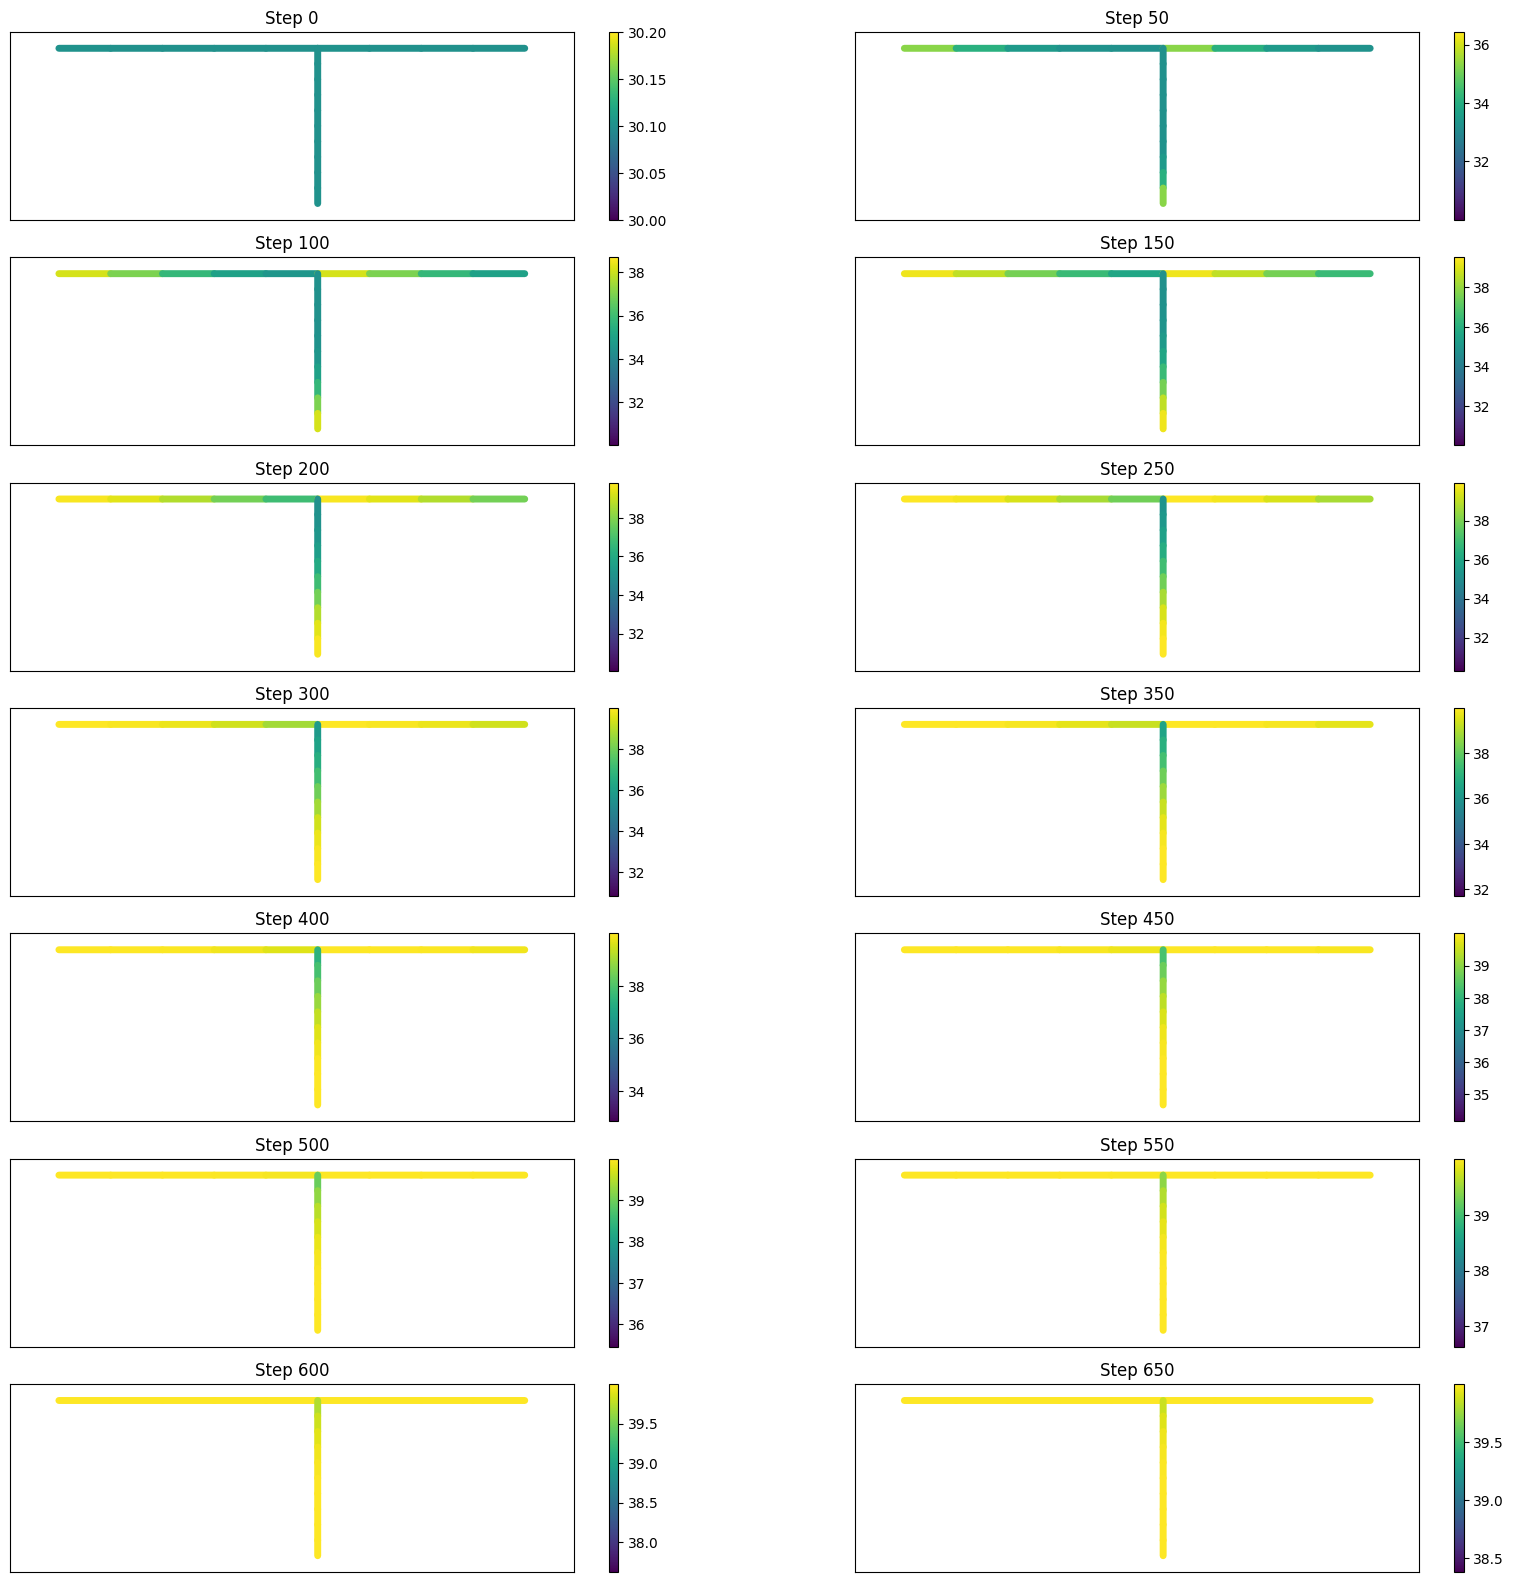

In [102]:
f, axs = plt.subplots(7, 2, figsize=(20,20))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*50}')

plt.plot()

# 1. Diverging

In [120]:
""" G = nx.DiGraph()

G.add_nodes_from([0,1,2,3,4,5])
G.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])

pos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}

nx.draw(G, pos, with_labels=True, font_weight='bold') """

" G = nx.DiGraph()\n\nG.add_nodes_from([0,1,2,3,4,5])\nG.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])\n\npos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}\n\nnx.draw(G, pos, with_labels=True, font_weight='bold') "